In [1]:
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from glob import glob
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
import torch.optim as optim
import wandb


In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: na21b051 (na21b051-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
train_path = '/content/inaturalist_12K/train'
test_path = '/content/inaturalist_12K/val'


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Image transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [8]:
train_data = ImageFolder(train_path, transform=train_transforms)
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
test_dataset = ImageFolder(test_path, transform=test_transforms)

In [9]:
dataset = DataLoader(train_dataset, shuffle=True, num_workers = 2)
dataiter = iter(dataset)
images, labels = next(dataiter)

In [10]:
print(images.shape)
image_dim = images.shape[2]

torch.Size([1, 3, 224, 224])


In [11]:

train_loader = DataLoader(train_dataset, batch_size = 30, shuffle=True, num_workers = 2)
dataiter = iter(train_loader)
images, labels = next(dataiter)

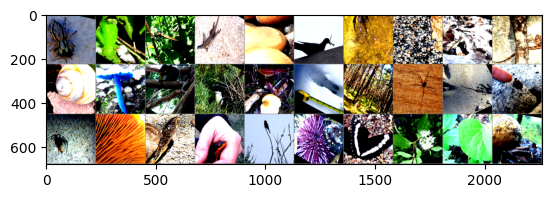

tensor([2, 5, 5, 9, 4, 3, 2, 0, 9, 9, 7, 4, 6, 3, 4, 6, 8, 2, 6, 6, 2, 4, 9, 0,
        3, 1, 5, 8, 8, 4])


In [12]:
import torchvision.utils as vutils

def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a few images from the batch
imshow(torchvision.utils.make_grid(images, nrow = 10))
print(labels)

In [13]:
def compute_output_dim(num_filters,num_layers, conv_filter_size, maxpool_filter_size):
    input_size = image_dim
    for i in range (num_layers):
      conv_output_dim = (input_size - conv_filter_size) + 1
      print('conv_output',conv_output_dim)
      maxpool_output_dim = np.floor((conv_output_dim - maxpool_filter_size)/2) + 1
      input_size = maxpool_output_dim
      print('maxpool_output',maxpool_output_dim)
    return int(maxpool_output_dim**2*num_filters)

In [14]:
compute_output_dim(16,5, 4, 2)

conv_output 221
maxpool_output 110.0
conv_output 107.0
maxpool_output 53.0
conv_output 50.0
maxpool_output 25.0
conv_output 22.0
maxpool_output 11.0
conv_output 8.0
maxpool_output 4.0


256

In [15]:
class CNN(nn.Module):
  def __init__(self, architecture, batch_norm, num_layers, num_filters, conv_filter_size, dropout, activation, dense_neurons):
    super(CNN, self).__init__()

    self.layers = []
    self.architecture = architecture
    self.batch_norm = batch_norm
    self.num_conv_layers = num_layers
    self.num_filters = num_filters
    self.conv_filter_size = conv_filter_size
    self.dropout = dropout
    self.dense_neurons = dense_neurons
    self.input_filters = 3
    self.maxpool_filter_size = 2

    if activation == 'ReLU':
      self.activation = nn.ReLU
    if activation == 'GELU':
      self.activation = nn.GELU
    if activation == "SiLU":
      self.activation = nn.SiLU
    if activation == "Mish":
      self.activation = nn.Mish
    if activation == 'LeakyReLU':
      self.activation = nn.LeakyReLU
    if activation == 'ELU':
      self.activation = nn.ELU

    if self.batch_norm == 'YES':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2

      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          print(i)
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          print('input_filters', self.input_filters)
          self.num_filters = int(self.num_filters/2)
          print('number of filters', self.num_filters)

      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

    if self.batch_norm == 'NO':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2

      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters/0.5

      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

   # Construct sequential module
    self.cnn_model = nn.Sequential()
    for i, layer in enumerate(self.layers):
      self.cnn_model.add_module(str(i), layer)

    output_dim = self.compute_output_dim(self.num_conv_layers, self.conv_filter_size, self.maxpool_filter_size)
    input_dense = (output_dim**2)*self.input_filters

    self.fc_model = nn.Sequential(
        nn.Linear(input_dense, self.dense_neurons),
        self.activation(),
        nn.Linear(self.dense_neurons,10)
    )

  def compute_output_dim(self, num_conv_layers, conv_filter_size, maxpool_filter_size):
    input_size = image_dim
    for i in range (num_conv_layers):
      conv_output_dim = (input_size - conv_filter_size) + 1
      maxpool_output_dim = np.floor((conv_output_dim - maxpool_filter_size)/2) + 1
      input_size = maxpool_output_dim
    return int(maxpool_output_dim)

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    print(x.shape)
    x = self.fc_model(x)
    return(x)


In [16]:
model = CNN(
    architecture = 'DOUBLE',
    batch_norm = 'YES',
    num_layers = 5,
    num_filters = 32,
    conv_filter_size = 5,
    dropout = 0.2,
    activation = 'LeakyReLU',
    dense_neurons = 128).to(device)

In [17]:
def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy


In [18]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 2)

In [19]:

#backprop
loss_cr = nn.CrossEntropyLoss()
la = optim.Adam(model.parameters())

In [26]:
loss_batch = []
loss_epoch = []
epochs = 5

# Initialize wandb run before the training loop
wandb.init(project="DA6401_Assignment_2") # Replace "your_project_name" with your desired project name

for epoch in tqdm(range(epochs)):
  for i, data in enumerate(train_loader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      la.zero_grad()
      y_pred = model(images)
      loss = loss_cr(y_pred, labels)
      loss.backward()
      la.step()
      loss_batch.append(loss.item())
  loss_epoch.append(loss.item())
  accuracy_val = accuracy(val_loader)
  accuracy_train = accuracy(train_loader)
  print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
  wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_train, 'epoch':epoch})
plt.plot(loss_epoch)
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])


  0%|          | 0/5 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [22]:
sweep_configuration = {
  'method': 'grid',
  'name': 'sweep',
  'metric': {'goal': 'maximize', 'name': 'accuracy_val'},
  'parameters': {
      'architecture': {'values': ['EQUAL','DOUBLE','HALF']},
      'batch_norm':{'values':['YES','NO']},
      'num_layers': {'values': [5]},
      'num_filters': {'values': [32]},
      'conv_filter_size': {'values': [5]},
      'dropout': {'values': [0.05,0.1,0.2]},
      'activation':{'values':['ReLU', 'GELU', 'LeakyReLU', 'SiLU', 'Mish']},
      'dense_neurons': {'values': [128]},
      'learning_rate': {'values': [1e-4,1e-5,1e-6]},
      'weight_decay': {'values': [0, 0.0005, 0.5]},
      'optimizer': {'values': ['Adam', 'NAdam','RAdam', 'AdamW', 'SGD']},
    } }

In [ ]:
def wandbsweeps():
  wandb.init(project = 'DA6401_Assignment_2')
  print('wandb initialize')
  wandb.run.name = (
        "bn"
        + str(wandb.config.batch_norm)
        + "nf"
        + str(wandb.config.num_filters)
        + "fs"
        + str(wandb.config.conv_filter_size)
        + "do"
        + str(wandb.config.dropout)
        + "lr"
        + str(wandb.config.learning_rate)
        + "opt"
        + wandb.config.optimizer
        + "af"
        + str(wandb.config.activation)
    )
  print('wandb run initialize')
  model = CNN(
    architecture=wandb.config.architecture,
    batch_norm = wandb.config.batch_norm,
    num_layers = wandb.config.num_layers,
    num_filters = wandb.config.num_filters,
    conv_filter_size = wandb.config.conv_filter_size,
    dropout = wandb.config.dropout,
    activation = wandb.config.activation,
    dense_neurons = wandb.config.dense_neurons).to(device)
  print('model')

  def accuracy(dataloader):
    total, correct_predictions = 0, 0
    for data in dataloader:
      X, Y = data
      X, Y = X.to(device), Y.to(device)
      Y_pred = model(X)
      _, pred = torch.max(Y_pred.data, 1)
      total += Y.size(0)
      correct_predictions += (pred == Y).sum().item()
      accuracy = (correct_predictions/total)*100
    return accuracy

  ## Loss and optimizer ##
  loss_cr = nn.CrossEntropyLoss()
  print('Loss')
  if wandb.config.optimizer == 'Adam':
    la = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'NAdam':
    la = optim.NAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay= wandb.config.weight_decay)
  elif wandb.config.optimizer == 'RAdam':
    la = optim.RAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'AdamW':
    la = optim.AdamW(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'SGD':
    la = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  else:
      raise ValueError("Invalid optimizer type.")

  print('optim')
  loss_batch = []
  loss_epoch = []
  epochs = 5
  for i in tqdm(range(epochs)):
    epoch = i+1
    for j, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        la.zero_grad()
        y_pred = model(images)
        loss = loss_cr(y_pred, labels)
        loss.backward()
        la.step()
        loss_batch.append(loss.item())
    loss_epoch.append(loss.item())
    accuracy_val = accuracy(val_loader)
    accuracy_train = accuracy(train_loader)
    print('training loop')
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
    wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_train, 'epoch':epoch})
  wandb.finish()

sweep_id = wandb.sweep(sweep= sweep_configuration, project = 'DA6401_Assignment_2')
wandb.agent(sweep_id, function = wandbsweeps)

Create sweep with ID: m5j25dvd
Sweep URL: https://wandb.ai/na21b051-indian-institute-of-technology-madras/DA6401_Assignment_2/sweeps/m5j25dvd


wandb: Agent Starting Run: s2vfmn1k with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:15<13:02, 195.71s/it]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 40%|████      | 2/5 [06:30<09:45, 195.06s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 23.20, Train acc: 23.33
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:46<06:30, 195.44s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 25.40, Train acc: 25.74
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [13:00<03:15, 195.07s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 25.90, Train acc: 27.15
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:14<00:00, 194.98s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 26.15, Train acc: 26.95


accuracy_training,▁▄▇██
accuracy_val,▁▄▇██
epoch,▁▃▅▆█
accuracy_training,26.95337
accuracy_val,26.15
epoch,5


wandb: Agent Starting Run: lh54h8z2 with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:17<13:10, 197.55s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 20.05, Train acc: 20.29
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:33<09:49, 196.63s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 22.85, Train acc: 22.72
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:50<06:33, 196.65s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 25.00, Train acc: 24.23
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [13:05<03:16, 196.04s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 25.55, Train acc: 27.07
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:21<00:00, 196.38s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 25.70, Train acc: 26.68


accuracy_training,▁▄▅██
accuracy_val,▁▄▇██
epoch,▁▃▅▆█
accuracy_training,26.67833
accuracy_val,25.7
epoch,5


wandb: Agent Starting Run: fgs9y5lb with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:12<12:50, 192.54s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 12.85, Train acc: 12.44
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:26<09:40, 193.37s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 15.95, Train acc: 17.81
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:40<06:27, 193.76s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 19.15, Train acc: 19.61
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [12:56<03:14, 194.71s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 21.15, Train acc: 21.69
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:10<00:00, 194.02s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 19.85, Train acc: 21.47


accuracy_training,▁▅▆██
accuracy_val,▁▄▆█▇
epoch,▁▃▅▆█
accuracy_training,21.46518
accuracy_val,19.85
epoch,5


wandb: Agent Starting Run: fcy38rrf with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:15<13:02, 195.66s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 21.75, Train acc: 20.60
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:30<09:46, 195.41s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 23.40, Train acc: 23.52
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:48<06:32, 196.22s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 25.75, Train acc: 25.07
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [13:02<03:15, 195.61s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 26.00, Train acc: 26.54
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:17<00:00, 195.57s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 27.15, Train acc: 27.48


accuracy_training,▁▄▆▇█
accuracy_val,▁▃▆▇█
epoch,▁▃▅▆█
accuracy_training,27.47843
accuracy_val,27.15
epoch,5


wandb: Agent Starting Run: r2bywsqy with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0.0005


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:14<12:57, 194.43s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 21.00, Train acc: 20.98
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:27<09:41, 193.90s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 23.80, Train acc: 22.94
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:44<06:30, 195.30s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 26.10, Train acc: 25.09
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [12:56<03:13, 193.95s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 26.85, Train acc: 26.99
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:08<00:00, 193.65s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 27.15, Train acc: 27.42


accuracy_training,▁▃▅██
accuracy_val,▁▄▇██
epoch,▁▃▅▆█
accuracy_training,27.41593
accuracy_val,27.15
epoch,5


wandb: Agent Starting Run: rkm0pd9o with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0.5


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:14<12:59, 194.86s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 17.65, Train acc: 18.21
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:26<09:39, 193.12s/it]

training loop
Epoch: 2/5, Validation acc: 20.65, Train acc: 19.28
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 60%|██████    | 3/5 [09:40<06:26, 193.20s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 20.00, Train acc: 20.52
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [12:54<03:13, 193.55s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 20.50, Train acc: 20.30
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:09<00:00, 193.82s/it]

training loop
Epoch: 5/5, Validation acc: 20.65, Train acc: 21.34


accuracy_training,▁▃▆▆█
accuracy_val,▁█▆██
epoch,▁▃▅▆█
accuracy_training,21.34017
accuracy_val,20.65
epoch,5


wandb: Agent Starting Run: 7eiz5k1s with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: RAdam
wandb: 	weight_decay: 0


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:12<12:51, 192.96s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 11.70, Train acc: 12.16
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:25<09:37, 192.44s/it]

training loop
Epoch: 2/5, Validation acc: 18.70, Train acc: 18.64
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 60%|██████    | 3/5 [09:35<06:22, 191.34s/it]

torch.Size([128, 288])
torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 20.80, Train acc: 19.95
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [12:46<03:11, 191.50s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 22.20, Train acc: 21.34
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [15:59<00:00, 191.95s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 22.35, Train acc: 21.92


accuracy_training,▁▆▇██
accuracy_val,▁▆▇██
epoch,▁▃▅▆█
accuracy_training,21.91524
accuracy_val,22.35
epoch,5


wandb: Agent Starting Run: rz2sy1mf with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: RAdam
wandb: 	weight_decay: 0.0005


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:09<12:38, 189.70s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 12.95, Train acc: 13.85
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:22<09:34, 191.60s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 18.70, Train acc: 18.30
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:34<06:23, 191.61s/it]

training loop
Epoch: 3/5, Validation acc: 20.25, Train acc: 19.34
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 80%|████████  | 4/5 [12:45<03:11, 191.62s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 21.80, Train acc: 20.90
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [15:59<00:00, 191.90s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 21.80, Train acc: 20.74


accuracy_training,▁▅▆██
accuracy_val,▁▆▇██
epoch,▁▃▅▆█
accuracy_training,20.74009
accuracy_val,21.8
epoch,5


wandb: Agent Starting Run: ypup847g with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: RAdam
wandb: 	weight_decay: 0.5


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:11<12:47, 191.87s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 12.25, Train acc: 11.55
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:24<09:37, 192.47s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 14.55, Train acc: 14.03
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:36<06:23, 192.00s/it]

training loop
Epoch: 3/5, Validation acc: 15.00, Train acc: 16.28
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 80%|████████  | 4/5 [12:45<03:10, 190.84s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 18.80, Train acc: 17.99
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [15:56<00:00, 191.25s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 19.70, Train acc: 18.81


accuracy_training,▁▃▆▇█
accuracy_val,▁▃▄▇█
epoch,▁▃▅▆█
accuracy_training,18.81485
accuracy_val,19.7
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zoic80wm with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: AdamW
wandb: 	weight_decay: 0


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:10<12:42, 190.52s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 21.10, Train acc: 20.93
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:23<09:35, 191.68s/it]

training loop
Epoch: 2/5, Validation acc: 23.35, Train acc: 23.13
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 60%|██████    | 3/5 [09:35<06:24, 192.02s/it]

training loop
Epoch: 3/5, Validation acc: 24.65, Train acc: 24.98
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([12

 80%|████████  | 4/5 [12:48<03:12, 192.51s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 26.10, Train acc: 26.20
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:04<00:00, 193.00s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 25.75, Train acc: 26.99


accuracy_training,▁▄▆▇█
accuracy_val,▁▄▆██
epoch,▁▃▅▆█
accuracy_training,26.99087
accuracy_val,25.75
epoch,5


wandb: Agent Starting Run: 0imdonvz with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: AdamW
wandb: 	weight_decay: 0.0005


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:15<13:00, 195.24s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 20.20, Train acc: 20.24
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 40%|████      | 2/5 [06:31<09:48, 196.05s/it]

torch.Size([63, 288])
training loop
Epoch: 2/5, Validation acc: 22.10, Train acc: 23.74
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 60%|██████    | 3/5 [09:45<06:30, 195.00s/it]

torch.Size([63, 288])
training loop
Epoch: 3/5, Validation acc: 25.40, Train acc: 25.58
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

 80%|████████  | 4/5 [12:56<03:13, 193.55s/it]

torch.Size([63, 288])
training loop
Epoch: 4/5, Validation acc: 25.05, Train acc: 26.44
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128

100%|██████████| 5/5 [16:10<00:00, 194.03s/it]

torch.Size([63, 288])
training loop
Epoch: 5/5, Validation acc: 27.35, Train acc: 27.83


accuracy_training,▁▄▆▇█
accuracy_val,▁▃▆▆█
epoch,▁▃▅▆█
accuracy_training,27.82848
accuracy_val,27.35
epoch,5


wandb: Agent Starting Run: bn0ajoeq with config:
wandb: 	activation: ReLU
wandb: 	architecture: EQUAL
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: AdamW
wandb: 	weight_decay: 0.5


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size(

 20%|██        | 1/5 [03:12<12:48, 192.12s/it]

torch.Size([63, 288])
training loop
Epoch: 1/5, Validation acc: 21.35, Train acc: 20.25
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128, 288])
torch.Size([128